In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_relationships.csv', 'train', 'sample_submission.csv']


In [2]:
#importing all package....
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf


import numpy.random as rng
from sklearn.utils import shuffle
from keras.layers import *
from keras.models import Model
import cv2
from PIL import Image

Using TensorFlow backend.


In [3]:
#preparing train data...................

train_data=pd.read_csv("../input/train_relationships.csv")
test_data=pd.read_csv("../input/train_relationships.csv")

train_data[:5]

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [4]:
train_data.describe()
train_data.isnull().sum()



p1    0
p2    0
dtype: int64

In [5]:
#add non-related column.......
list1=list(train_data.p1)

list2=list(train_data.p2)
new_list=list1[::-1]


temp_data=pd.DataFrame({'p1':new_list,'p2':list2})
#print(temp_data)
train_data=pd.concat([train_data,temp_data])
train_data.describe()

#creating whole label................................................
label=[]

for i in range(0,7196):
    if i<3599:
        label.append(1)
    else:
        label.append(0)
#print(label)

In [6]:
def add_image_path(x):
    image_path="../input/train/"+x
    temp_path="../input/train/F0002/MID1/P00017_face3.jpg"
    #print(image_path)
    if os.path.exists(image_path):
        #print(os.listdir(image_path)[0])
        path=os.path.join(image_path,os.listdir(image_path)[0])
        #print(path)
        return path
    else:
        return temp_path

In [7]:
train_data['p1_path']=train_data.p1.apply(lambda x:add_image_path(x))

train_data['p2_path']=train_data.p2.apply(lambda x:add_image_path(x))


train_data['is_related']=np.array(label)


In [8]:

from sklearn.utils import shuffle
train_data = shuffle(train_data)
#now check the train_data 
train_data.head()

,p1,p2,p1_path,p2_path,is_related
981,F0282/MID2,F0282/MID5,../input/train/F0282/MID2/P03011_face7.jpg,../input/train/F0282/MID5/P03007_face8.jpg,1
1009,F0284/MID3,F0284/MID1,../input/train/F0284/MID3/P03036_face2.jpg,../input/train/F0284/MID1/P03039_face2.jpg,1
3577,F0009/MID7,F1000/MID6,../input/train/F0009/MID7/P11742_face2.jpg,../input/train/F1000/MID6/P10584_face1.jpg,0
3386,F0074/MID6,F0952/MID2,../input/train/F0074/MID6/P11167_face1.jpg,../input/train/F0952/MID2/P10030_face1.jpg,0
1011,F0284/MID4,F0284/MID1,../input/train/F0284/MID4/P03031_face1.jpg,../input/train/F0284/MID1/P03039_face2.jpg,1


In [9]:
train_data.fillna(method='ffill', axis=1)
train_data.isnull().sum()


p1            0
p2            0
p1_path       0
p2_path       0
is_related    0
dtype: int64

In [10]:
train_data.tail(10)
train_data.isnull().sum()

p1            0
p2            0
p1_path       0
p2_path       0
is_related    0
dtype: int64

In [11]:
#making x_train and y_train..here..........................

train_image_1=[]
train_image_2=[]
train_label=[]

h=0
w=0

for image_1,image_2,label in zip(train_data['p1_path'],train_data['p2_path'],train_data['is_related']):
    
        img_1=Image.open(image_1)
        #print(image_1,image_2)
        
        area=(50,52,150,160)
        cropped_1=img_1.crop(area)
        
        img_2=Image.open(image_2)
        cropped_2=img_2.crop(area)
        
        new1=np.array(cropped_1,dtype='uint8')/255
        new2=np.array(cropped_2,dtype='uint8')/255
        
        width, height = img_1.size
        if width>w:
            w=width
        if height>h:
            h=height
        
        train_image_1.append(new1)
        train_image_2.append(new2)
        
        train_label.append(label)


        
        
print(h,w)
train_image_1= np.array(train_image_1)
train_image_2= np.array(train_image_2)



224 224


In [12]:
"""
input_image_1 = Input(shape=(224, 224, 3))
input_image_2 = Input(shape=(224, 224, 3))

face = Conv2D(32, kernel_size=(3, 3))(input_image_1)
face = Conv2D(32, kernel_size=(3, 3))(face)
face = Flatten()(face)

sig = Conv2D(32, kernel_size=(3, 3))(input_image_2)
sig = Conv2D(32, kernel_size=(3, 3))(sig)
sig = Flatten()(sig)

output = concatenate([sig, face])
output = Dense(2, activation='softmax')(output)
model = Model(inputs=[input_face, input_sig], outputs=[output])
"""

#model-1 structure is defining here.........................

model1 = Sequential()
model1.add(Conv2D(64, (1,1), activation='relu', padding='same', input_shape=(108, 100, 3))) 
model1.add(MaxPooling2D((1, 1), padding='same'))
model1.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model1.add(MaxPooling2D((1, 1), padding='same'))
model1.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
model1.add(MaxPooling2D((1, 1), padding='same'))
model1.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
model1.add(MaxPooling2D((1, 1), padding='same'))


#model-2 structure is defining here..................
model2 = Sequential()
model2.add(Conv2D(64, (1, 1), activation='relu', padding='same', input_shape=(108, 100, 3))) 
model2.add(MaxPooling2D((1, 1), padding='same'))
model2.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model2.add(MaxPooling2D((1, 1), padding='same'))
model2.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
model2.add(MaxPooling2D((1, 1), padding='same'))
model2.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
model2.add(MaxPooling2D((1, 1), padding='same'))


#merging the two model................................
mergeOut=Add()([model1.output,model2.output])

mergeout=Flatten()(mergeOut)

mergeout=Dense(64,activation='relu')(mergeout)

mergeout=Dropout(.2)(mergeOut)
mergeout=Dense(32,activation='relu')(mergeout)
mergeout=Dropout(.2)(mergeout)

mergeout=Flatten()(mergeout)

#output layer.......
mergeout=Dense(1,activation='sigmoid')(mergeout)

newModel=Model([model1.input,model2.input],mergeout)

newModel.summary() 

newModel.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 108, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5_input (InputLayer)     (None, 108, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 108, 100, 64) 256         conv2d_1_input[0][0]             
__________________________________________________________________________________________________
conv2d_5 (Conv2D)    

In [13]:
val_image_1=train_image_1[:1000]
val_image_2=train_image_2[:1000]
val_label=train_label[:1000]

In [14]:
newModel.fit([train_image_1,train_image_2],train_label,epochs=100,validation_data=([val_image_1,val_image_2],val_label))



Instructions for updating:
Use tf.cast instead.
Train on 7196 samples, validate on 1000 samples
Epoch 1/100
7196/7196 [==============================] - 15s 2ms/step - loss: 0.7231 - acc: 0.4992 - val_loss: 0.6925 - val_acc: 0.5350
Epoch 2/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6869 - acc: 0.5347 - val_loss: 0.6559 - val_acc: 0.6090
Epoch 3/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6765 - acc: 0.5564 - val_loss: 0.6853 - val_acc: 0.5470
Epoch 4/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6835 - acc: 0.5267 - val_loss: 0.6770 - val_acc: 0.5570
Epoch 5/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6612 - acc: 0.5824 - val_loss: 0.6663 - val_acc: 0.5650
Epoch 6/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6553 - acc: 0.5987 - val_loss: 0.6346 - val_acc: 0.6240
Epoch 7/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.6592 - a

7196/7196 [==============================] - 13s 2ms/step - loss: 0.4330 - acc: 0.7853 - val_loss: 0.3856 - val_acc: 0.8300
Epoch 59/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.4247 - acc: 0.7935 - val_loss: 0.3725 - val_acc: 0.8400
Epoch 60/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.4204 - acc: 0.7918 - val_loss: 0.3662 - val_acc: 0.8340
Epoch 61/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.4041 - acc: 0.8018 - val_loss: 0.3589 - val_acc: 0.8280
Epoch 62/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.4014 - acc: 0.8038 - val_loss: 0.3456 - val_acc: 0.8640
Epoch 63/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.3890 - acc: 0.8146 - val_loss: 0.3599 - val_acc: 0.8290
Epoch 64/100
7196/7196 [==============================] - 13s 2ms/step - loss: 0.3827 - acc: 0.8138 - val_loss: 0.3218 - val_acc: 0.8810
Epoch 65/100
7196/7196 [==============================

In [15]:
test_data=pd.read_csv("../input/sample_submission.csv")
test_data.describe()
test_data.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [16]:
# new data frame with split value columns 
new = test_data["img_pair"].str.split("-", n = 1, expand = True) 
  
# making separate first name column from new data frame 
test_data["image_1"]= new[0] 
  
# making separate last name column from new data frame 
test_data["image_2"]= new[1] 

In [17]:
test_image_1=[]
test_image_2=[]
for img_1,img_2 in zip(test_data['image_1'],test_data['image_2']):
    img_1=os.path.join("../input/test/",img_1)
    img_2=os.path.join("../input/test/",img_2)
    img_1=Image.open(img_1)
        #print(image_1,image_2)
        
    area=(50,52,150,160)
    cropped_1=img_1.crop(area)
    img_2=Image.open(img_2)
    area=(50,52,150,160)
    cropped_2=img_2.crop(area)
        
    new1=np.array(cropped_1,dtype='uint8')
    new2=np.array(cropped_2,dtype='uint8')
    test_image_1.append(new1)
    test_image_2.append(new2)
    
        

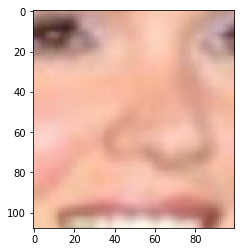

In [18]:
plt.imshow(test_image_1[0])

In [19]:
pred=newModel.predict([test_image_1,test_image_2])


In [20]:
for i in range(0,100):
    print(pred[i])

[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[0.]


In [21]:
subm=pd.DataFrame({'img_pair':test_data['img_pair']})
subm['is_related']=pred

subm.to_csv('submission.csv',index=False)
